Rludwig. Last updated 17 March 2021. This is a credit card portfolio, probability of payment utilizing PCA and XGboost.

In [1]:
import pandas as pd
import numpy as np
import os
from various_functions import dum_sign
import sidetable
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [2]:
os.chdir('C:\\Bossa Nova\\collections agency models\\OA\\Development CC April 2019')

In [3]:
df = pd.read_stata("CC_OA_carga_historica_pythn_prjct.dta")

clean up pago_general column to get 0 for no payment and 1 for payment

In [4]:
df['pago_general'] = df['pago_general'].replace(['master only (1)'],'1')

In [5]:
df['pago_general'] = pd.to_numeric(df['pago_general'], errors='coerce')

In [6]:
df.head()

,location,banco,agencia,dir_reg,dt_nasc,uf,iden_tel1,ddd_tel1,iden_tel2,ddd_tel2,...,saldo_ccmrcl6,mesasig,dataasig,pj,cnpj15,cpf11,cpfcnpj15,valorpagamento,datapagamento,pago_general
0,010102,237,0313,4354,20/01/1994,SP,X,00,V,11,...,741.700012,201902,2019-02-27,1.0,000001813000104,00000181304,000001813000104,2369.94,22/01/2019,1
1,101010,,00309,,19/02/1963,RJ,V,21,X,00,...,0.000000,201901,2019-01-31,0.0,000002457000004,00000245704,00000000245704,NaN,,0
2,101010,,00685,,23/12/1982,CE,X,00,X,00,...,0.000000,201812,2018-12-11,0.0,000002683000021,00000268321,00000000268321,NaN,,0
3,101010,,00679,,15/02/1986,PA,X,00,X,00,...,0.000000,201901,2019-01-28,0.0,000003672000022,00000367222,00000000367222,368.74,01/02/2019,1
4,101010,,04025,,17/06/1963,RJ,X,00,X,00,...,0.000000,201901,2019-01-04,0.0,000004527000069,00000452769,00000000452769,NaN,,0


In [7]:
df.describe()

,vl_vcto_cor,resp_contr,resp_cliente,dias_atraso,saldo_totcli6,saldo_cart6,saldo_ccmrcl6,pj,valorpagamento,pago_general
count,3.063470e+05,306347.000000,306347.000000,306347.000000,3.063470e+05,3.063470e+05,3.063470e+05,306347.000000,115388.000000,306347.000000
mean,1.445289e+03,1242.849435,4278.905676,14.282180,4.030688e+03,1.557948e+03,2.472626e+03,0.168117,1086.804070,0.376658
std,8.541782e+03,13806.790601,31265.528131,11.003552,2.750265e+04,9.018295e+03,2.524375e+04,0.372949,3069.818025,0.484549
min,4.900000e+01,0.000000,0.000000,5.000000,4.935000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,2.290000e+02,0.000000,0.000000,7.000000,3.109400e+02,1.859900e+02,0.000000e+00,0.000000,187.710000,0.000000
50%,5.210000e+02,0.000000,0.000000,10.000000,7.282500e+02,5.028900e+02,0.000000e+00,0.000000,442.305000,0.000000
75%,1.093000e+03,0.000000,0.000000,16.000000,1.771610e+03,1.127645e+03,2.821950e+02,0.000000,1022.640000,1.000000
max,3.290767e+06,599958.000000,599958.000000,120.000000,3.290767e+06,3.290767e+06,2.944226e+06,1.000000,329000.000000,1.000000


In [8]:
df.columns

Index(['location', 'banco', 'agencia', 'dir_reg', 'dt_nasc', 'uf', 'iden_tel1',
       'ddd_tel1', 'iden_tel2', 'ddd_tel2', 'iden_tel3', 'ddd_tel3',
       'iden_tel4', 'ddd_tel4', 'iden_tel5', 'ddd_tel5', 'iden_tel6',
       'ddd_tel6', 'rating', 'dt_desde', 'nat_oper', 'carteira', 'vcto_antig',
       'vl_vcto_cor', 'resp_contr', 'resp_cliente', 'ident_seg', 'produto',
       'subproduto', 'familia', 'convenio', 'bs1', 'cs1', 'ct1',
       'num_contrato', 'dias_atraso', 'data_lig', 'term_code', 'cont_lig',
       'saldo_totcli6', 'saldo_cart6', 'saldo_ccmrcl6', 'mesasig', 'dataasig',
       'pj', 'cnpj15', 'cpf11', 'cpfcnpj15', 'valorpagamento', 'datapagamento',
       'pago_general'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306347 entries, 0 to 306346
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   location        306347 non-null  object        
 1   banco           306347 non-null  object        
 2   agencia         306347 non-null  object        
 3   dir_reg         306347 non-null  object        
 4   dt_nasc         306347 non-null  object        
 5   uf              306347 non-null  object        
 6   iden_tel1       306347 non-null  object        
 7   ddd_tel1        306347 non-null  object        
 8   iden_tel2       306347 non-null  object        
 9   ddd_tel2        306347 non-null  object        
 10  iden_tel3       306347 non-null  object        
 11  ddd_tel3        306347 non-null  object        
 12  iden_tel4       306347 non-null  object        
 13  ddd_tel4        306347 non-null  object        
 14  iden_tel5       306347 non-null  obj

In [10]:
df.stb.freq(['term_code'])

,term_code,count,percent,cumulative_count,cumulative_percent
0,,306347,100.0,306347,100.0


drop columns we don't need:

In [11]:
df = df.drop(['mesasig', 'ct1', 'data_lig', 'term_code', 'cont_lig',
              'cnpj15', 'cpfcnpj15'], axis = 1) 

array([[<AxesSubplot:title={'center':'vl_vcto_cor'}>,
        <AxesSubplot:title={'center':'resp_contr'}>,
        <AxesSubplot:title={'center':'resp_cliente'}>],
       [<AxesSubplot:title={'center':'dias_atraso'}>,
        <AxesSubplot:title={'center':'saldo_totcli6'}>,
        <AxesSubplot:title={'center':'saldo_cart6'}>],
       [<AxesSubplot:title={'center':'saldo_ccmrcl6'}>,
        <AxesSubplot:title={'center':'dataasig'}>,
        <AxesSubplot:title={'center':'pj'}>],
       [<AxesSubplot:title={'center':'valorpagamento'}>,
        <AxesSubplot:title={'center':'pago_general'}>, <AxesSubplot:>]],
      dtype=object)

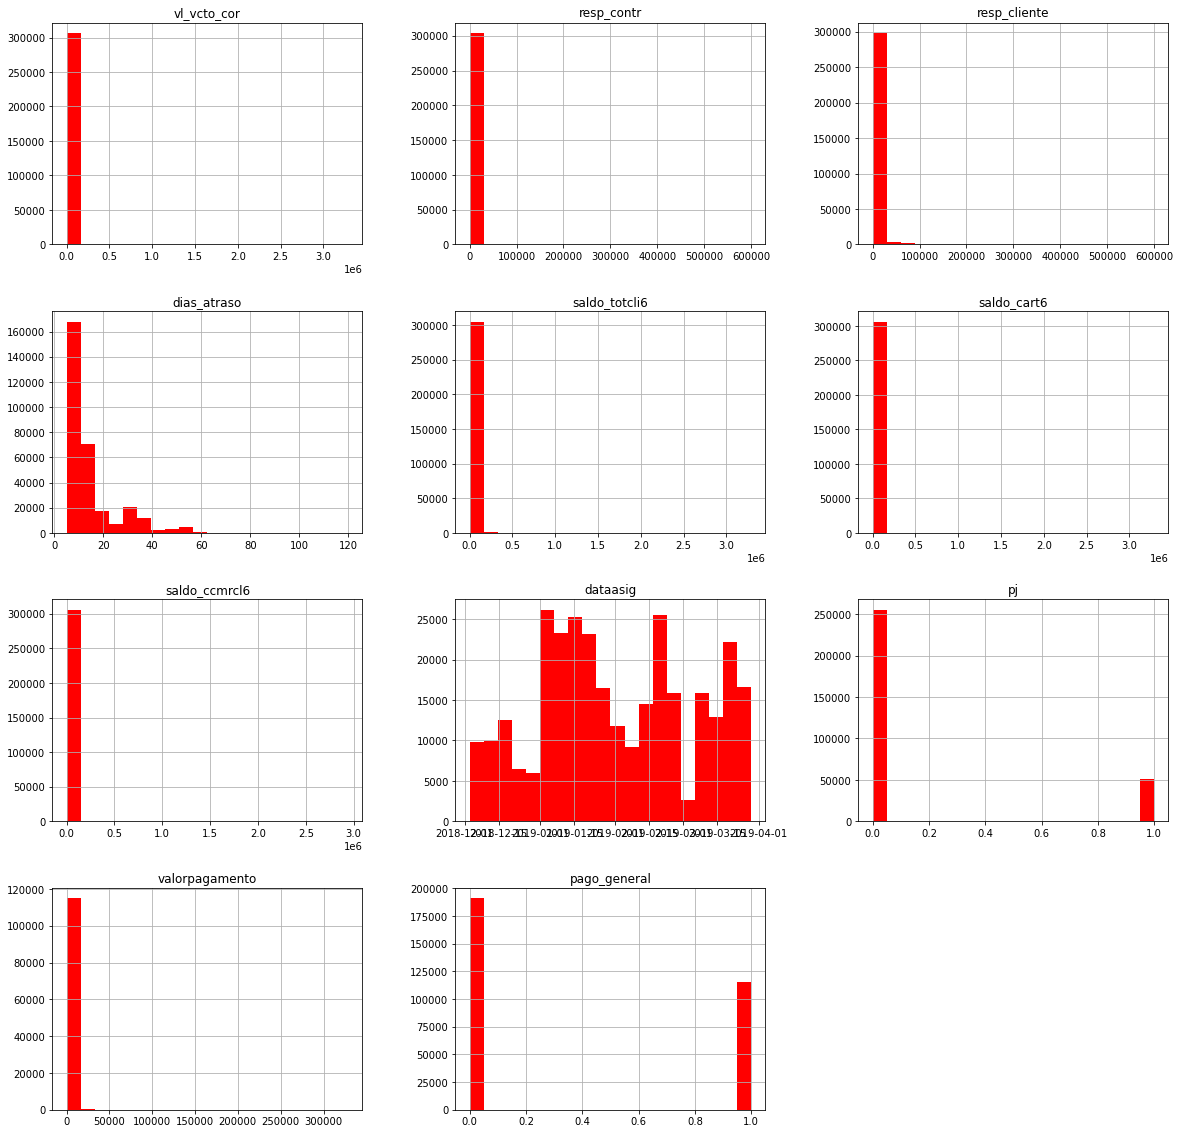

In [12]:
df.hist(bins = 20, figsize = (20,20), color = 'r')

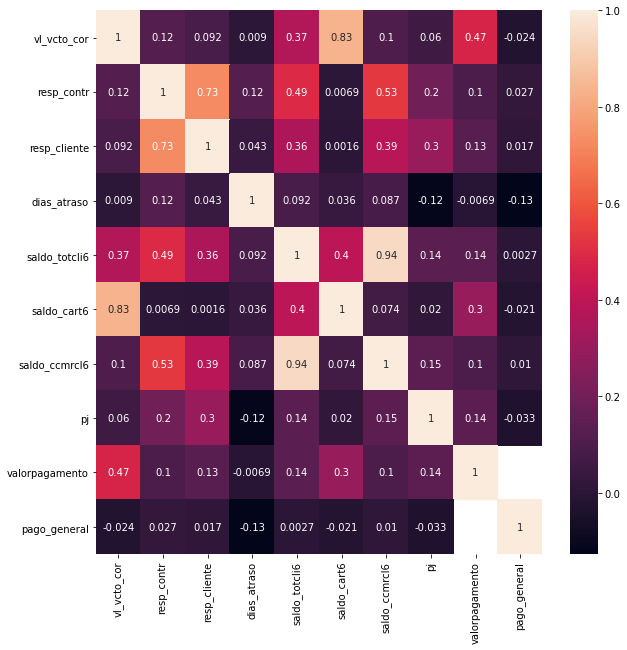

In [13]:
plt.figure(figsize = (10,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [14]:
print(list(df.columns))

['location', 'banco', 'agencia', 'dir_reg', 'dt_nasc', 'uf', 'iden_tel1', 'ddd_tel1', 'iden_tel2', 'ddd_tel2', 'iden_tel3', 'ddd_tel3', 'iden_tel4', 'ddd_tel4', 'iden_tel5', 'ddd_tel5', 'iden_tel6', 'ddd_tel6', 'rating', 'dt_desde', 'nat_oper', 'carteira', 'vcto_antig', 'vl_vcto_cor', 'resp_contr', 'resp_cliente', 'ident_seg', 'produto', 'subproduto', 'familia', 'convenio', 'bs1', 'cs1', 'num_contrato', 'dias_atraso', 'saldo_totcli6', 'saldo_cart6', 'saldo_ccmrcl6', 'dataasig', 'pj', 'cpf11', 'valorpagamento', 'datapagamento', 'pago_general']


drop highly correlated variables

In [15]:
df = df.drop(['saldo_ccmrcl6', 'vl_vcto_cor', 'resp_contr'  ], axis = 1) 

In [16]:
df['location'].value_counts()

101010    254770
010102     30772
301010     20805
Name: location, dtype: int64

In [17]:
df['banco'].value_counts()

       275575
237     30772
Name: banco, dtype: int64

In [18]:
df['agencia'].value_counts()

04025    39936
03750     3659
03726      723
00265      340
00452      301
         ...  
0604         1
5726         1
0377         1
3197         1
7875         1
Name: agencia, Length: 8669, dtype: int64

In [19]:
df = pd.get_dummies(df, columns = ['location', 'banco', 'uf', 'rating', 'ident_seg', 'bs1', 'cs1'], drop_first = True)

In [20]:
dummy = pd.Series(df['agencia'], name='agencia')
dummy_df= dum_sign(dummy, 0.01)

In [21]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('agencia', axis = 1) 

In [22]:
df['dir_reg'].value_counts()

        275575
4264       490
8533       392
8565       385
4669       384
         ...  
4678         3
8761         2
4631         2
4024         1
4090         1
Name: dir_reg, Length: 131, dtype: int64

dir_reg has aprox. 90% blank. will convert column to zero for blanks 1 non-blank

In [23]:
df['dir_reg'] = df['dir_reg'].apply(lambda x: 0 if x == '' else 1)

In [24]:
df['dt_nasc'] = pd.to_datetime(df['dt_nasc'], errors='coerce')

In [25]:
df['age'] = (df['dataasig'] - df['dt_nasc']).astype('<m8[Y]')
df = df.drop('dt_nasc', axis = 1) 

Telephone variables with ddd can be dropped since we can get valid phone count
using the "V" value in the iden columns.

In [26]:
cols = [c for c in df.columns if c.lower()[:3] != 'ddd']
df = df[cols] 

In [27]:
df['iden_tel1'].value_counts()

X    272696
V     33651
Name: iden_tel1, dtype: int64

will replace valid phone value "V" with 1 so we can get a sum of valid phones

In [28]:
df.iloc[:, 1:7] = df.iloc[:, 1:7].replace({'V': 1,'X':0}).fillna(0)

In [29]:
cols = list(df.columns)

In [30]:
cols = cols[1:7]

In [31]:
df['total_phones'] = df[cols].sum(axis=1)

In [32]:
df.drop(cols, axis=1, inplace=True)

create a new tenure variable using dt_desde and dataasig

In [33]:
df['dt_desde'] = pd.to_datetime(df['dt_desde'], errors='coerce')
df['tenure'] = (df['dataasig'] - df['dt_desde']).astype('<m8[Y]')
df = df.drop('dt_desde', axis = 1) 

In [34]:
df['nat_oper'].value_counts()

3      275575
001     10993
090      7936
013      5057
057      2641
093      1989
012      1438
091       343
058       285
033        33
078        17
102        16
092        12
014         8
007         2
005         2
Name: nat_oper, dtype: int64

In [35]:
dummy = pd.Series(df['nat_oper'], name='nat_oper')
dummy_df= dum_sign(dummy, 0.01)

In [36]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('nat_oper', axis = 1) 

In [37]:
df['carteira'].value_counts()

       275575
455      7936
722      4426
351      2838
379      2758
842      2640
385      2312
DCC      1989
530      1906
227      1431
331       544
729       373
375       343
773       309
469       308
809       285
EXL        95
GFC        45
266        33
771        32
393        30
532        17
288        15
136        13
340        12
CAF        11
712         8
144         6
621         6
448         5
944         5
CFF         5
349         4
451         4
117         4
226         4
263         2
404         2
700         2
406         2
591         2
551         2
124         1
039         1
304         1
510         1
321         1
044         1
841         1
688         1
Name: carteira, dtype: int64

In [38]:
dummy = pd.Series(df['carteira'], name='carteira')
dummy_df= dum_sign(dummy, 0.005)

In [39]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(['carteira', 'vcto_antig', 'familia'], axis = 1) #vcto_antig same as dias_atraso
#familia highly corr with produto

In [40]:
df['produto'].value_counts()

000    277980
004     15608
011      7936
002      2926
005      1531
019       340
012        18
006         8
Name: produto, dtype: int64

In [41]:
df['prod_000'] = df['produto'].apply(lambda x: 0 if x != '000' else 1)
df['prod_004'] = df['produto'].apply(lambda x: 0 if x != '004' else 1)
df['prod_011'] = df['produto'].apply(lambda x: 0 if x != '011' else 1)
df = df.drop('produto', axis = 1)

In [42]:
df['subprod_000'] = df['subproduto'].apply(lambda x: 0 if x != '000' else 1)
df['subprod_006'] = df['subproduto'].apply(lambda x: 0 if x != '006' else 1)
df['subprod_061'] = df['subproduto'].apply(lambda x: 0 if x != '061' else 1)
df = df.drop('subproduto', axis = 1)

In [43]:
df['convenio'].value_counts()

000000000    295104
000004930      2015
000007537      1902
000009151      1136
000009152       678
              ...  
000006654         1
000006030         1
000015423         1
000055518         1
000004707         1
Name: convenio, Length: 186, dtype: int64

In [44]:
dummy = pd.Series(df['convenio'], name='convenio')
dummy_df= dum_sign(dummy, 0.005)

In [45]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('convenio', axis = 1)

get unique count of contracts for each cpf

In [46]:

nval_df = df.groupby('cpf11').num_contrato.agg(nvals='nunique')

merge unique contract count df with original df

In [47]:
df = pd.merge(df, nval_df, left_on ='cpf11', right_on = 'cpf11', how='left')

drop the others column from all dummies to avoid dummy trap

In [48]:
cols = [col for col in df.columns if '_others' not in col]
df = df[cols] 

In [49]:
del cols
del nval_df
del dummy
del dummy_df

In [50]:
df['dir_reg'].head()

0    1
1    0
2    0
3    0
4    0
Name: dir_reg, dtype: int64

In [51]:
df['dir_reg'].value_counts()

0    275575
1     30772
Name: dir_reg, dtype: int64

In [52]:
df.dtypes

dir_reg                 int64
resp_cliente            int32
num_contrato           object
dias_atraso             int16
saldo_totcli6         float32
                       ...   
subprod_061             int64
convenio_000000000      uint8
convenio_000004930      uint8
convenio_000007537      uint8
nvals                   int64
Length: 103, dtype: object

get a subset of variables to review in correlation matrix

In [53]:
corr_df = df.iloc[:, np.r_[0:15, 42:103]]

<AxesSubplot:>

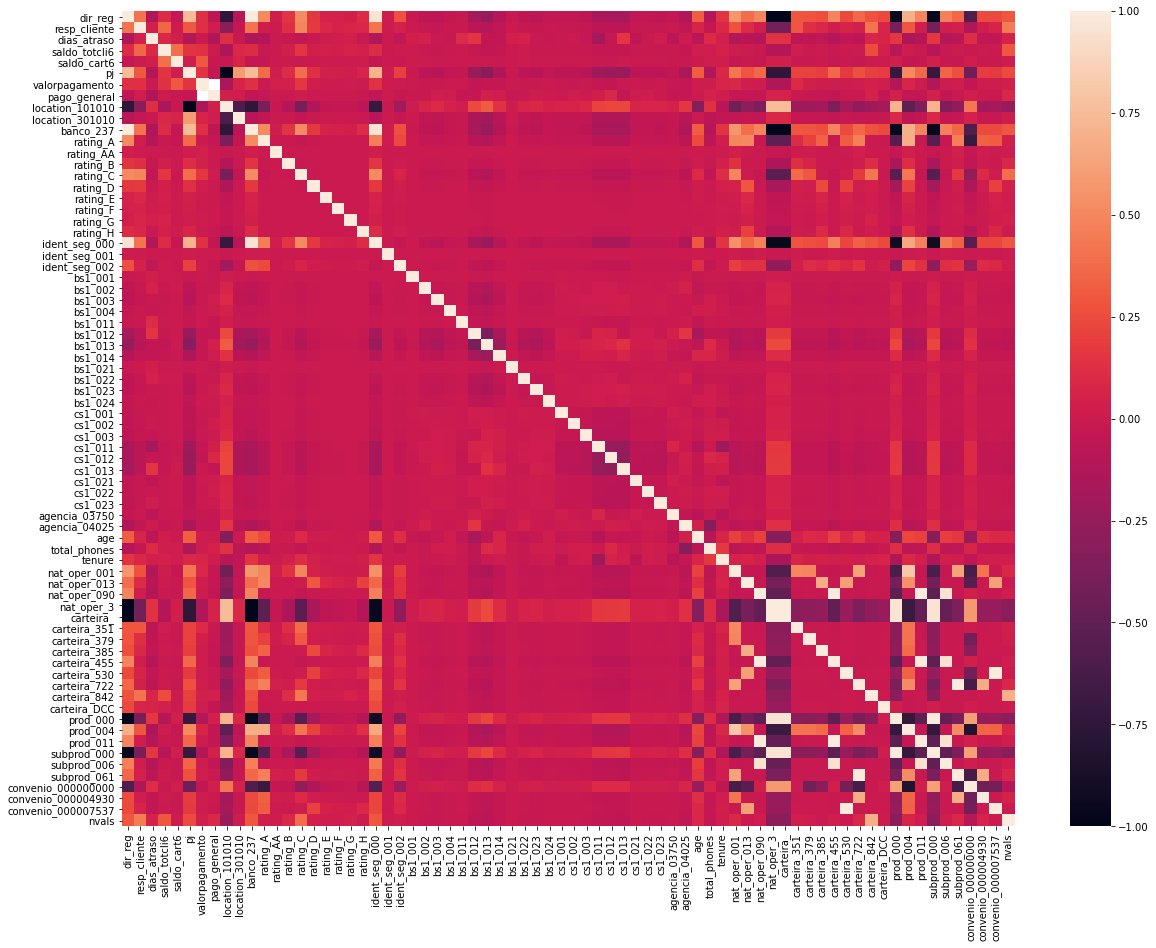

In [54]:
corr_matrix = corr_df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix)

will drop one of the pairs from too highly correlated variables.

In [55]:
df = df.drop(['dir_reg', 'ident_seg_000', 'nat_oper_090', 'subprod_006', 'subprod_000', 'subprod_061'] , axis = 1)

# Get Cumulative Info for key variables then dedupe by CPF

In [56]:
def trans_max(*args, key):
    """ This function transforms the column by performing a groupby on the key
    column and summing the values."""
    
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('max')
    return df[arg]

In [57]:
trans_max('pj',
          'pago_general', 'location_101010', 'location_301010', 'banco_237',
          'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF',
          'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA',
          'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO',
          'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'rating_A',
          'rating_AA', 'rating_B', 'rating_C', 'rating_D', 'rating_E', 'rating_F',
          'rating_G', 'rating_H', 'ident_seg_002',
          'bs1_001', 'bs1_002', 'bs1_003', 'bs1_004', 'bs1_011', 'bs1_012',
          'bs1_013', 'bs1_014', 'bs1_021', 'bs1_022', 'bs1_023', 'bs1_024',
          'cs1_001', 'cs1_002', 'cs1_003', 'cs1_011', 'cs1_012', 'cs1_013',
          'cs1_021', 'cs1_022', 'cs1_023', 'agencia_03750', 'agencia_04025',
          'nat_oper_001', 'nat_oper_013', 'nat_oper_3', 'carteira_',
          'carteira_351', 'carteira_379', 'carteira_385', 'carteira_455',
          'carteira_530', 'carteira_722', 'carteira_842', 'carteira_DCC',
          'prod_000', 'prod_004', 'prod_011', 'convenio_000000000', 'convenio_000004930',
          'convenio_000007537', 'nvals' , key = 'cpf11')

0         1
1         1
2         1
3         1
4         1
         ..
306342    1
306343    1
306344    1
306345    2
306346    2
Name: nvals, Length: 306347, dtype: int64

In [58]:
def trans_sum(*args, key):
    """ This function transforms the column by performing a groupby on the key
    column and summing the values."""
    
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('sum')
    return df[arg]

In [59]:
trans_sum('resp_cliente','total_phones',
          'saldo_totcli6', 'saldo_cart6','valorpagamento', key='cpf11')

0          2369.94
1             0.00
2             0.00
3           368.74
4             0.00
            ...   
306342     5166.47
306343    13378.34
306344     1235.62
306345      664.63
306346      664.63
Name: valorpagamento, Length: 306347, dtype: float64

In [60]:
def trans_mean(*args, key):
    """ This function transform the column by performing a groupby on the key
    column and summing the values."""
   
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('mean')
    return df[arg]

In [61]:
trans_mean('age', 'tenure', 'dias_atraso', key='cpf11')

0          5.00
1         15.00
2         35.00
3         15.00
4          9.00
          ...  
306342     9.00
306343    11.00
306344    15.00
306345     6.25
306346     6.25
Name: dias_atraso, Length: 306347, dtype: float64

In [62]:
df = df.drop_duplicates(subset=['cpf11'])

In [63]:
print(list(df.columns))

['resp_cliente', 'num_contrato', 'dias_atraso', 'saldo_totcli6', 'saldo_cart6', 'dataasig', 'pj', 'cpf11', 'valorpagamento', 'datapagamento', 'pago_general', 'location_101010', 'location_301010', 'banco_237', 'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'rating_A', 'rating_AA', 'rating_B', 'rating_C', 'rating_D', 'rating_E', 'rating_F', 'rating_G', 'rating_H', 'ident_seg_001', 'ident_seg_002', 'bs1_001', 'bs1_002', 'bs1_003', 'bs1_004', 'bs1_011', 'bs1_012', 'bs1_013', 'bs1_014', 'bs1_021', 'bs1_022', 'bs1_023', 'bs1_024', 'cs1_001', 'cs1_002', 'cs1_003', 'cs1_011', 'cs1_012', 'cs1_013', 'cs1_021', 'cs1_022', 'cs1_023', 'agencia_03750', 'agencia_04025', 'age', 'total_phones', 'tenure', 'nat_oper_001', 'nat_oper_013', 'nat_oper_3', 'carteira_', 'carteira_351', 'carteira_379', 'carteira_385', 

In [64]:
df = df.drop(['num_contrato', 'dataasig', 'cpf11', 'datapagamento'], axis = 1) 

In [65]:
# split the dataframe into target and features

df_target = df['pago_general']
df_final = df.drop(columns =['pago_general', 'valorpagamento'])

In [66]:
df_final.shape

(264534, 91)

In [69]:
df_target.shape

(264534,)

In [70]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df_final[['age']])
df_final['age'] = imr.transform(df_final[['age']]).ravel()

In [71]:
#spliting the data in to test and train sets

X_train, X_test, y_train, y_test = train_test_split(df_final, df_target, test_size = 0.2)



In [72]:
X_train.reset_index(drop=True, inplace=True)

In [73]:
X_train.shape

(211627, 91)

In [74]:
y_train.shape

(211627,)

In [75]:
X_test.shape

(52907, 91)

In [76]:
X_test.shape

(52907, 91)

# Standardizing the Data for PCA

In [77]:

scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
train_pca = scaler.transform(X_train)
test_pca = scaler.transform(X_test)

In [78]:
pca = PCA(.95)

In [79]:
pca.fit(train_pca)

PCA(n_components=0.95)

In [80]:
pca.n_components_

68

Transform both the training set and the test set.

In [81]:
train_pca = pca.transform(train_pca)
test_pca = pca.transform(test_pca)

In [132]:
train_pca.shape

(211627, 68)

In [82]:
!pip install xgboost

In [133]:
X_train.head()

,resp_cliente,dias_atraso,saldo_totcli6,saldo_cart6,pj,location_101010,location_301010,banco_237,uf_AC,uf_AL,...,carteira_722,carteira_842,carteira_DCC,prod_000,prod_004,prod_011,convenio_000000000,convenio_000004930,convenio_000007537,nvals
0,0,34.0,489.309998,489.309998,0.0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,10.0,73.400002,73.400002,1.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,0,25.0,635.909973,635.909973,0.0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,0,5.0,238.580002,238.580002,0.0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,0,35.0,231.059998,231.059998,0.0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [134]:


model = XGBClassifier(use_label_encoder = False, learning_rate=0.01, n_estimators=100,
                      subsample = 0.8, colsample_bytree = 0.8, max_depth = 3, gamma=1)

model.fit(train_pca, y_train)

[15:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [135]:
# make predictions on test data

predict = model.predict(test_pca)

In [136]:
predict

array([0, 0, 0, ..., 0, 0, 0])

# Assess trained model performance on training dataset

In [137]:
predict_train = model.predict(train_pca)

cm = confusion_matrix(y_train, predict_train)


In [138]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

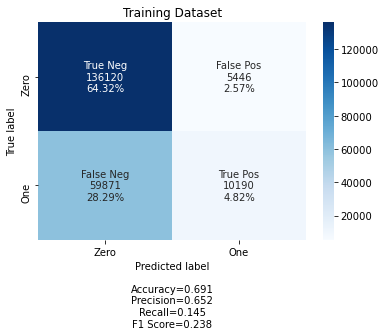

In [139]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Training Dataset')

In [140]:
auc = roc_auc_score(y_train, predict_train)
auc

0.5534874974343346

# Assess trained model performance on testing dataset

In [141]:
cm = confusion_matrix(y_test, predict)

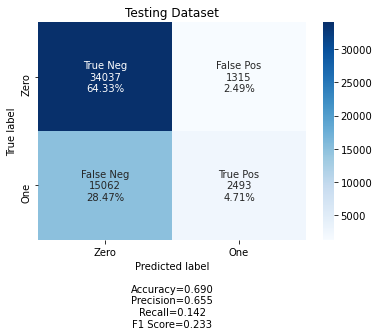

In [142]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Testing Dataset')

Generate ROC Curves and AUC

In [143]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predict)
tr_fpr, tr_tpr, _ = roc_curve(y_train, predict_train)

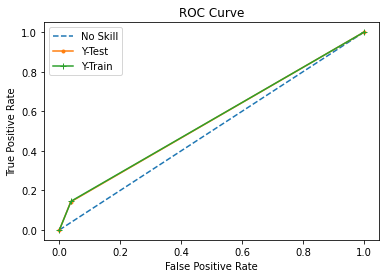

In [144]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Y-Test')
plt.plot(tr_fpr, tr_tpr, marker='+', label='Y-Train' )
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# title
plt.title('ROC Curve')
# show the plot
plt.show()

In [145]:
auc = roc_auc_score(y_test, predict)
auc

0.5524067467073548

In [146]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
epochs_hist = %time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.62414	validation_0-error:0.29958	validation_1-auc:0.62282	validation_1-error:0.30153
[1]	validation_0-auc:0.62473	validation_0-error:0.29958	validation_1-auc:0.62358	validation_1-error:0.30153
[2]	validation_0-auc:0.62492	validation_0-error:0.29958	validation_1-auc:0.62391	validation_1-error:0.30153
[3]	validation_0-auc:0.62507	validation_0-error:0.29958	validation_1-auc:0.62407	validation_1-error:0.30153
[4]	validation_0-auc:0.62507	validation_0-error:0.29958	validation_1-auc:0.62408	validation_1-error:0.30153
[5]	validation_0-auc:0.64045	validation_0-error:0.29958	validation_1-auc:0.63900	validation_1-error:0.30153
[6]	validation_0-auc:0.64044	validation_0-error:0.29958	validation_1-auc:0.63898	validation_1-error:0.30153
[7]	validation_0-auc:0.64047	validation_0-error:0.29958	validation_1-auc:0.63922	validation_1-error:0.30153
[8]	validation_0-auc:0.64047	validation_0-error:0.29958	validation_1-auc:0.63922	validation_1-error:0.30153
[9]	validation_0-auc:0.64047

In [147]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

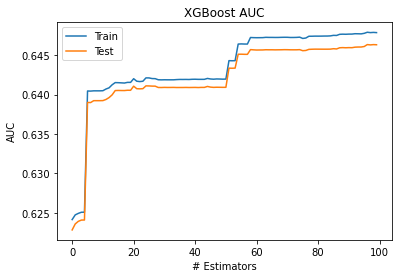

In [148]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.xlabel('# Estimators')
plt.show()

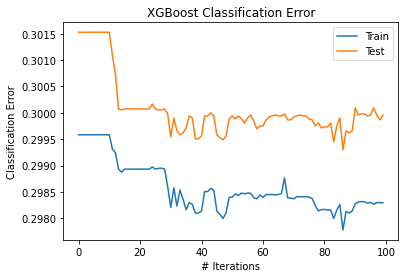

In [149]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.xlabel('# Iterations')
plt.show()

# Fine tuning hyperparameters (first time)

In [150]:

#reduce estimators to 50 and increase max depth to 5
model = XGBClassifier(use_label_encoder = False, learning_rate=0.01, n_estimators=50,
                      subsample = 0.8, colsample_bytree = 0.8, max_depth = 5, gamma=1)

model.fit(train_pca, y_train)

[15:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [151]:
# make predictions on test data

predict = model.predict(test_pca)

In [152]:
predict

array([0, 0, 0, ..., 0, 0, 0])

# Assess trained model performance on training dataset

In [153]:
predict_train = model.predict(train_pca)

cm = confusion_matrix(y_train, predict_train)


In [154]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

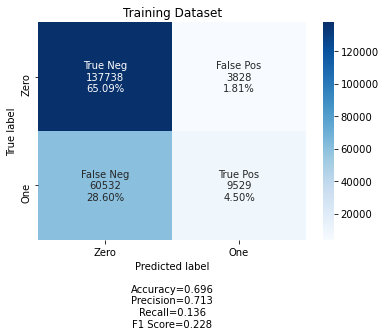

In [155]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Training Dataset')

In [156]:
auc = roc_auc_score(y_train, predict_train)
auc

0.5544848286660286

# Assess trained model performance on testing dataset

In [157]:
cm = confusion_matrix(y_test, predict)

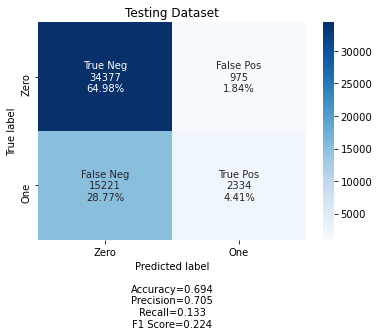

In [158]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Testing Dataset')

Generate ROC Curves and AUC

In [159]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predict)
tr_fpr, tr_tpr, _ = roc_curve(y_train, predict_train)

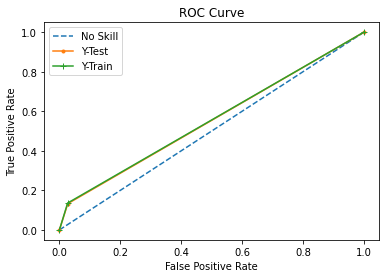

In [160]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Y-Test')
plt.plot(tr_fpr, tr_tpr, marker='+', label='Y-Train' )
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# title
plt.title('ROC Curve')
# show the plot
plt.show()

In [161]:
auc = roc_auc_score(y_test, predict)
auc

0.5526869026508289

In [162]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
epochs_hist = %time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.64381	validation_0-error:0.29892	validation_1-auc:0.64254	validation_1-error:0.30009
[1]	validation_0-auc:0.65425	validation_0-error:0.29883	validation_1-auc:0.65193	validation_1-error:0.30000
[2]	validation_0-auc:0.65446	validation_0-error:0.29885	validation_1-auc:0.65205	validation_1-error:0.30019
[3]	validation_0-auc:0.65444	validation_0-error:0.29897	validation_1-auc:0.65228	validation_1-error:0.30062
[4]	validation_0-auc:0.65580	validation_0-error:0.29864	validation_1-auc:0.65370	validation_1-error:0.29985
[5]	validation_0-auc:0.65868	validation_0-error:0.29894	validation_1-auc:0.65642	validation_1-error:0.30058
[6]	validation_0-auc:0.65878	validation_0-error:0.29869	validation_1-auc:0.65661	validation_1-error:0.29990
[7]	validation_0-auc:0.65871	validation_0-error:0.29867	validation_1-auc:0.65651	validation_1-error:0.29990
[8]	validation_0-auc:0.65867	validation_0-error:0.29874	validation_1-auc:0.65649	validation_1-error:0.30024
[9]	validation_0-auc:0.65854

In [163]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

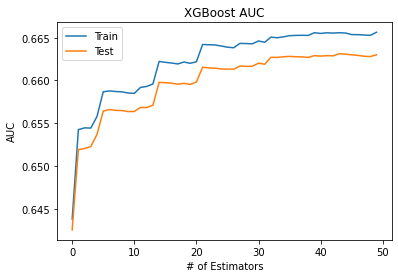

In [164]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.xlabel('# of Estimators')
plt.show()

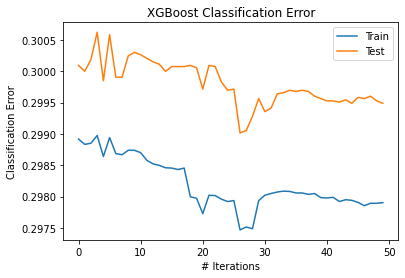

In [165]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.xlabel('# Iterations')
plt.show()

# Fine tuning hyperparameters (additional changes multiple times)

In [166]:

model = XGBClassifier(use_label_encoder = False, learning_rate=0.01, n_estimators=20,
                      subsample = 1, colsample_bytree = 0.8, max_depth = 20, gamma=1)

model.fit(train_pca, y_train)

[15:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [167]:
# make predictions on test data

predict = model.predict(test_pca)

In [168]:
predict

array([0, 0, 0, ..., 0, 0, 0])

# Assess trained model performance on training dataset

In [169]:
predict_train = model.predict(train_pca)

cm = confusion_matrix(y_train, predict_train)


In [170]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

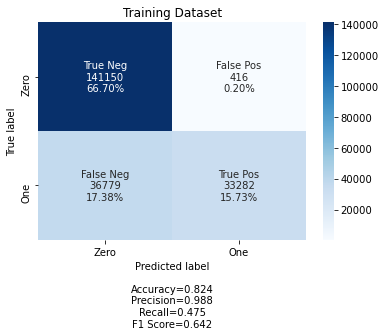

In [171]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Training Dataset')

In [172]:
auc = roc_auc_score(y_train, predict_train)
auc

0.7360523089834337

# Assess trained model performance on testing dataset

In [173]:
cm = confusion_matrix(y_test, predict)

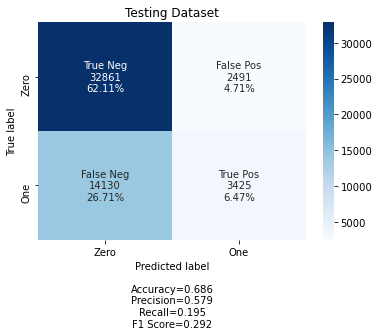

In [174]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Testing Dataset')

Generate ROC Curves and AUC

In [175]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predict)
tr_fpr, tr_tpr, _ = roc_curve(y_train, predict_train)

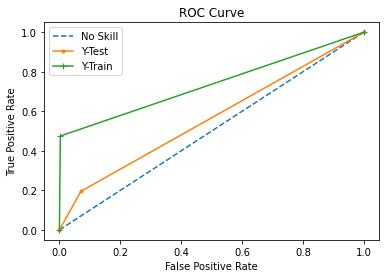

In [176]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Y-Test')
plt.plot(tr_fpr, tr_tpr, marker='+', label='Y-Train' )
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# title
plt.title('ROC Curve')
# show the plot
plt.show()

In [177]:
auc = roc_auc_score(y_test, predict)
auc

0.5623191682056503

In [178]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
epochs_hist = %time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.77128	validation_0-error:0.24731	validation_1-auc:0.67042	validation_1-error:0.31181
[1]	validation_0-auc:0.80234	validation_0-error:0.23306	validation_1-auc:0.68029	validation_1-error:0.30450
[2]	validation_0-auc:0.82276	validation_0-error:0.22509	validation_1-auc:0.68634	validation_1-error:0.30057
[3]	validation_0-auc:0.82426	validation_0-error:0.22755	validation_1-auc:0.69098	validation_1-error:0.29737
[4]	validation_0-auc:0.82744	validation_0-error:0.22629	validation_1-auc:0.69307	validation_1-error:0.29684
[5]	validation_0-auc:0.83845	validation_0-error:0.22572	validation_1-auc:0.69431	validation_1-error:0.29620
[6]	validation_0-auc:0.84080	validation_0-error:0.22427	validation_1-auc:0.69637	validation_1-error:0.29505
[7]	validation_0-auc:0.84204	validation_0-error:0.22330	validation_1-auc:0.69660	validation_1-error:0.29497
[8]	validation_0-auc:0.84329	validation_0-error:0.22313	validation_1-auc:0.69619	validation_1-error:0.29537
[9]	validation_0-auc:0.84307

In [179]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

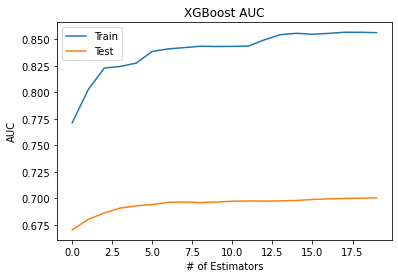

In [180]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.xlabel('# of Estimators')
plt.show()

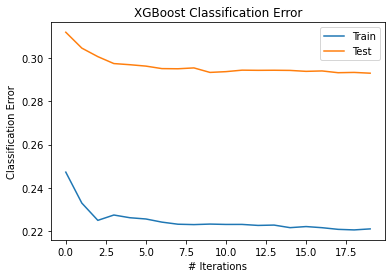

In [181]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.xlabel('# Iterations')
plt.show()